# Import Libraries

In [1]:
from collections import Counter
import re
import math
import random
import timeit
import sys
import numpy as np
import random
import hashlib
import matplotlib.pyplot as plt
import heapq 
from collections import defaultdict

# Lossy Counting

In [2]:
class LossyCounting:
    def __init__(self, epsilon, f):
        self.epsilon = epsilon
        self.f = f
        self.window = int(1 / self.epsilon)
        self.current_bucket = 1
        self.bucket_ids = {}
        self.count = Counter()

    def element_counting(self, data):
        i = 0
        for element in data:
            #element = int(element.rstrip('\n'))
            i += 1
            if element in self.count:
                self.count[element] += 1
            else:
                self.count[element] = 1
                self.bucket_ids[element] = self.current_bucket - 1
            if i % self.window ==0:
                for key in list(self.count.keys()):
                    if self.count[key] == 1:
                        del self.count[key]
                        del self.bucket_ids[key]
                    else:
                        self.count[key] -= 1	
                self.current_bucket += 1

    def return_counting(self, N):
        for key in list(self.count.keys()):
            if self.count[key] < (self.f - self.epsilon) * N:
                del self.count[key]
        return self.count

# lc_test = LossyCounting(0.01,0.3)
# elements = ['apple', 'banana', 'apple', 'orange', 'banana', 'banana', 'apple', 'apple', 'banana']

# lc_test.element_counting(elements)

# print("heavy hitters and its counts：", lc_test.return_counting(len(elements)))


# Sticky Sampling

In [3]:
class StickySampling:
    def __init__(self, f, epsilon, delta):
        '''
        ref: https://www.inf.ed.ac.uk/teaching/courses/exc/slides/dataStreams02.pdf 
        
        support threshold: s (0, 1)
        erro parameter: epsilon (0, 1)
        probability of failure: delta (0, 1)
        '''
        self.f = f
        self.epsilon = epsilon
        self.delta = delta
        self.window = int (1/self.epsilon * math.log10(1/(self.f * self.delta)))
        self.r = 1  # Sampling rate r grows in proportion to window size
        self.count = Counter()

    def element_counting(self, data):
        i = 0
        for element in data:
            i += 1
            if element in self.count:
                self.count[element] += 1                # Go through elements if counter exists,increase it
            else:
                if random.random() < (1 / self.r):  
                    self.count[element] = 1             # If not, create one with probability 1/r
            
            if i % self.window == 0:                    # Window boundary
                self.r *= 2                             # r growing at the same rate as window size
                self.window *= 2

                for key in list(self.count.keys()):
                    while (random.random() < 0.5):      # Repeatedly toss an unbiased coin until the coin toss is successful
                        if self.count[key] == 1:
                            del self.count[key]         #  If  becomes count becomes 0 during this process, we delete the entry
                            break
                        else:
                            self.count[key] -= 1	    # diminishing count by one for every unsuccessful toss


    def return_counting(self, N):
        for key in list(self.count.keys()):
            if self.count[key] < (self.f - self.epsilon) * N:
                del self.count[key]
        return self.count
            

# Count-Min Sketch

In [4]:
class CountMinSketch:
    def __init__(self, width, depth):
        '''
        width: size of hash tables (K)
        depth: amount of hash tables (N)
        talbe: total number of buckets with K*N np array
        func : params of a, b, p for N hash function ( a * x + b) % p
        '''
        self.width = width
        self.depth = depth
        self.table = np.zeros((depth, width), dtype=int)
        self.func = np.zeros((depth, 3), dtype=int)
        self.generate_hash_fun()

    # Reference: https://stackoverflow.com/questions/567222/simple-prime-number-generator-in-python
    def is_prime(self,p):
        for i in range(2, int(math.sqrt(p)) + 1):
            if p % i == 0:
                return False
        return True

    def generate_prime(self):
        '''
        generate a prime that is bigger than the size of hash tables(K)
        '''
        c = random.randint(1,100)
        prime = self.width * c + 1
        while not self.is_prime(prime):
            prime += 1
        return prime

    def generate_hash_fun(self):
        for i in range(self.depth):
            p = self.generate_prime()
            # modifty to make sure a and b are int?
            a = random.randint(1,p-1)
            b = random.randint(1,p-1)
            self.func[i] = [a, b, p]

    def hash_fun(self, x, a, b, p):
        ans = (a * x + b) % p
        return ans

    def add(self, input):
        #Reference: https://stackoverflow.com/questions/12492137/python-sum-of-ascii-values-of-all-characters-in-a-string
        #x = sum(ord(c) for c in input) # convert string into integer
        #https://stackoverflow.com/questions/16008670/how-to-hash-a-string-into-8-digits
        x =int(hashlib.sha1(input.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
        for d in range (self.depth):
            a = self.func[d][0]
            b = self.func[d][1]
            p = self.func[d][2]
            index = self.hash_fun(x,a,b,p) % self.width
            self.table[d, index] += 1

    def count(self, input):
        min_count = float('inf')
        x =int(hashlib.sha1(input.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
        for d in range (self.depth):
            a = self.func[d][0]
            b = self.func[d][1]
            p = self.func[d][2]
            min_count = min(min_count, self.table[d, self.hash_fun(x,a,b,p) % self.width])
        return min_count

# Misra Gries

In [5]:
def misra_gries(data, f):
	count = Counter()
	k = 1/f
	for d in data:
		# d = int(d.rstrip('\n'))
		if len(count)< k-1 or d in count:
			count[d] += 1
		else:
			for key in list(count.keys()):
				count[key] -= 1
				if count[key] == 0:
					del count[key]
	return count

# AMS Sketch

In [6]:
#AMS Sketch
class AMSSketch:
    def __init__(self, depth=10, buckets=20):
        """
        Initializes the AMS sketch with specified depth and buckets.

        :param depth: The number of hash functions to use.
        :param buckets: The number of buckets per hash function.
        """
        self.depth = depth
        self.buckets = buckets
        self.counts = np.zeros((depth, buckets))
        self.test = np.random.randint(1, 1_000_000, size=(6, depth))
        self.count = 0

    def _hash31(self, a, b, item):
        """
        Generates a pairwise independent hash using given coefficients.

        :param a: Coefficient a for hashing.
        :param b: Coefficient b for hashing.
        :param item: The item to hash.
        :return: The resulting hash.
        """
        return (a * item + b) % 2**32

    def _fourwise(self, a, b, c, d, item):
        """
        Generates a four-wise independent hash using given coefficients.

        :param a: Coefficient a for hashing.
        :param b: Coefficient b for hashing.
        :param c: Coefficient c for hashing.
        :param d: Coefficient d for hashing.
        :param item: The item to hash.
        :return: The resulting hash.
        """
        return (a * item**3 + b * item**2 + c * item + d) % 2**32

    def add(self, item, increment=1):
        """
        Adds an item to the sketch, updating the counts.

        :param item: The item to add.
        :param increment: The count to increment by.
        """
        self.count += increment

        for i in range(self.depth):
            hash_index = self._hash31(self.test[0][i], self.test[1][i], item) % self.buckets
            sign = 1 if self._fourwise(self.test[2][i], self.test[3][i], self.test[4][i], self.test[5][i], item) % 2 == 1 else -1
            self.counts[i, hash_index] += sign * increment

    def estimate_count(self, item, runs=5):
        """
        Estimates the frequency count of an item by averaging over multiple runs.

        :param item: The item to estimate.
        :param runs: The number of runs to average.
        :return: The average estimated count.
        """
        estimates = []

        for _ in range(runs):
            run_estimates = []

            for i in range(self.depth):
                hash_index = self._hash31(self.test[0][i], self.test[1][i], item) % self.buckets
                sign = 1 if self._fourwise(self.test[2][i], self.test[3][i], self.test[4][i], self.test[5][i], item) % 2 == 1 else -1
                run_estimates.append(sign * self.counts[i, hash_index])

            estimates.append(np.median(run_estimates))

        return np.mean(estimates)

# Space Saving


In [7]:
class Counters:
    def __init__(self, item, count, error):
        self.item = item
        self.count = count
        self.error = error


class SpaceSavingPlusMinus:
    def __init__(self, capacity):
        """ Initialize the Space-Saving+- algorithm with a given capacity. """
        self.capacity = capacity
        self.counters = {}
        self.deletions = []  # Initialize the list to store deletions

    def process_insertion(self, item):
        """ Process an insertion of an item in the data stream, updating the sketch. """
        if item in self.counters:
            # Increment the count for an existing item
            self.counters[item].count += 1
            self.counters[item].error += 1
        elif len(self.counters) < self.capacity:
            # Add a new counter if there's space
            self.counters[item] = Counters(item, 1, 0)
        else:
            # Find the least frequent item and replace it
            least_frequent = min(self.counters.values(), key=lambda c: c.count)
            self.counters.pop(least_frequent.item)
            self.counters[item] = Counters(item, least_frequent.count + 1, least_frequent.count)

    def process_deletions(self):
        """ Process the list of deletions, updating the sketch. """
        for item in self.deletions:
            if item in self.counters:
                # Decrement the count for an existing item
                self.counters[item].count -= 1
            else:
                # Find the item with maximum error
                max_error_item = max(self.counters.values(), key=lambda c: c.error)
                # Decrement the count and error for the item with maximum error
                max_error_item.count -= 1
                max_error_item.error -= 1
        # Clear the deletions list after processing
        self.deletions.clear()

    def get_frequencies(self):
        """ Get the current frequency counts for items in the sketch. """
        return {k: v.count for k, v in self.counters.items()}

    def get_error_terms(self):
        """ Get the current error terms for items in the sketch. """
        return {k: v.error for k, v in self.counters.items()}

# Brute Force

In [8]:
def brute_force(data):
	count = Counter()
	for d in data:
		# d = int(d.rstrip('\n'))
		count[d] += 1
	return count

# Compare and Analysis

In [11]:
file_path = 'Pride_and_Prejudice.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    book_text = file.read()
#Reference: https://www.guru99.com/python-regular-expressions-complete-tutorial.html
words = re.findall(r'\b\w+\b', book_text.lower())

#no_common = 20
#words_to_count = ['the', 'to', 'of', 'and', 'her', 'i', 'a', 'in']
top_20_words= Counter(words).most_common(20)
no_common = 20
words_to_count = [i[0] for i in top_20_words]

cm_result = {}



# Setting Lossy Counting
lc_start = timeit.default_timer()
#lc_Pride_and_Prejudice = LossyCounting(0.0001,0.015)
lc_Pride_and_Prejudice = LossyCounting(0.0001,0.0085)
lc_Pride_and_Prejudice.element_counting(words)
lc_result = lc_Pride_and_Prejudice.return_counting(len(words))
lc_stop = timeit.default_timer()
lc_time = lc_stop - lc_start
lc_space = sys.getsizeof(lc_result)
print("lc done")

# Setting Sticky Sampling
ss_start = timeit.default_timer()
#ss_Pride_and_Prejudice = StickySampling(0.015, 0.0001, 0.00001)
ss_Pride_and_Prejudice = StickySampling(0.0095, 0.001, 0.001)
ss_Pride_and_Prejudice.element_counting(words)
ss_result = ss_Pride_and_Prejudice.return_counting(len(words))
ss_stop = timeit.default_timer()
ss_time = ss_stop - ss_start
ss_space = sys.getsizeof(ss_result)
print("ss done")

# Setting Misra_Gries
mg_start = timeit.default_timer()
mg_result = misra_gries(words, 0.0085)
mg_stop = timeit.default_timer()
mg_time = mg_stop - mg_start
mg_space = sys.getsizeof(mg_result)
print("mg done")

# Setting Count-Min Sketch
cm_start = timeit.default_timer()
cms = CountMinSketch(50, 300)
for element in words:
    cms.add(element)
cm_stop = timeit.default_timer()
cm_time = cm_stop - cm_start
cm_space = sys.getsizeof(cms) + cms.table.nbytes + cms.func.nbytes
for word in words_to_count:
    estimated_count = cms.count(word)
    cm_result[word] = estimated_count

print("cm done")

# Setting AMS Sketch
ams_start = timeit.default_timer()
sketch = AMSSketch(depth=50, buckets=300)

for element in words:
    sketch.add(hash(element))

ams_stop = timeit.default_timer()
ams_time = ams_stop - ams_start
ams_space = sys.getsizeof(sketch) + sketch.counts.nbytes

# AMS results
ams_result = {}
for word in words_to_count:
    ams_result[word] = sketch.estimate_count(hash(word))

print("ams done")

# setting for Space Saving
sss_start = timeit.default_timer()

sss = SpaceSavingPlusMinus(capacity=300)

for word in re.findall(r'\b\w+\b', book_text.lower()):
    sss.process_insertion(word)
sss.process_deletions()

sss_stop = timeit.default_timer()
sss_time = sss_stop - sss_start
sss_space = sys.getsizeof(sss) + sum([sys.getsizeof(c) for c in sss.counters.values()])

# Get SpaceSaving results
sss_result = sss.get_frequencies()

# Compare specific words
sss_compared = {word: sss_result.get(word, 0) for word in words_to_count}

print("sss done")




# Setting Brute Force
bt_start = timeit.default_timer()
bt_result = brute_force(words)
bt_stop = timeit.default_timer()
bt_time = bt_stop - bt_start
bt_space = sys.getsizeof(bt_result)
print("bt done")


print(len(words))
print("Lossy Counting Result: ", lc_result)
print("Sticky Sampling Result: ", ss_result)
print("Misra Gries Result: ", mg_result.most_common(no_common))
print("CountMin Sketch Result: ", cm_result)
print("AMS Sketch Result: ", ams_result)
print("Spac Saving Result: ", sss_compared)
print("Brute Force Result: ", bt_result.most_common(no_common))
print("-------------------")
print("Lossy Counting Time: ", lc_time)
print("Sticky Sampling Time: ", ss_time)
print("Misra Gries Time: ", mg_time)
print("CountMin Sketch Time: ", cm_time)
print("AMS Sketch Time: ", ams_time)
print("Space Saving Time: ", sss_time)
print("Brute Force Time: ", bt_time)
print("-------------------")
print("Lossy Counting Space: ", lc_space)
print("Sticky Sampling Space: ", ss_space)
print("Misra Gries Space: ", mg_space)
print("CountMin Sketch Space: ", cm_space)
print("AMS Sketch Space: ", ams_space)
print("Space Saving Space: ", sss_space)
print("Brute Force Space: ", bt_space)
print("-------------------")



lc done
ss done
mg done


C:\Users\Gus Li\AppData\Local\Temp\ipykernel_42444\2199264513.py:41: RuntimeWarning: overflow encountered in long_scalars
  ans = (a * x + b) % p


cm done
ams done
sss done
bt done
131914
Lossy Counting Result:  Counter({'the': 4833, 'to': 4392, 'of': 3947, 'and': 3821, 'her': 2247, 'i': 2085, 'a': 2081, 'in': 2038, 'was': 1861, 'she': 1719, 'that': 1607, 'it': 1590, 'not': 1507, 'you': 1404, 'he': 1337, 'his': 1276, 'be': 1267, 'as': 1226, 'had': 1168, 'with': 1136})
Sticky Sampling Result:  Counter({'the': 4840, 'to': 4398, 'of': 3949, 'and': 3814, 'her': 2257, 'i': 2096, 'a': 2088, 'in': 2049, 'was': 1868, 'she': 1728, 'that': 1620, 'it': 1599, 'not': 1517, 'you': 1410, 'he': 1345, 'his': 1281, 'be': 1273, 'as': 1236, 'had': 1181, 'with': 1145})
Misra Gries Result:  [('the', 3947), ('to', 3506), ('of', 3061), ('and', 2935), ('her', 1365), ('i', 1201), ('a', 1195), ('in', 1152), ('was', 986), ('she', 843), ('that', 723), ('it', 704), ('not', 621), ('you', 543), ('he', 470), ('his', 401), ('be', 391), ('as', 343), ('had', 309), ('with', 250)]
CountMin Sketch Result:  {'the': 5552, 'to': 5091, 'of': 4764, 'and': 4480, 'her': 2990

#### Algorithm Execution Time Comparison Plotting

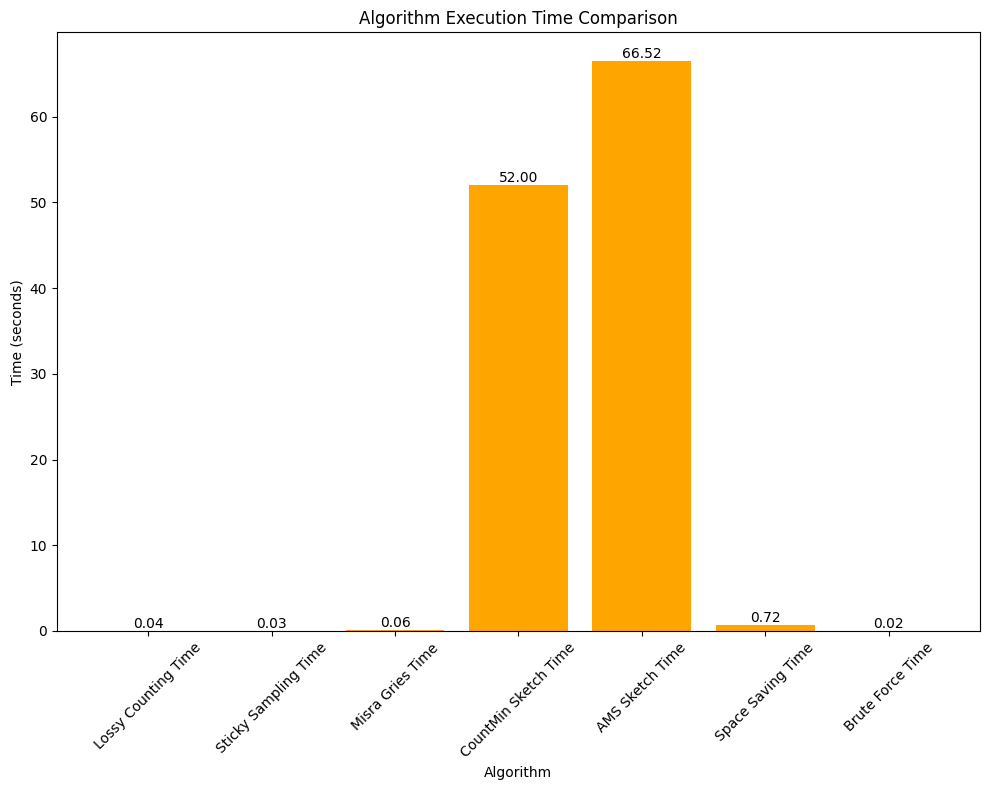

In [12]:

times = [lc_time, ss_time, mg_time, cm_time, ams_time, sss_time ,bt_time]
labels = ['Lossy Counting Time', 'Sticky Sampling Time', 'Misra Gries Time', 'CountMin Sketch Time', "AMS Sketch Time",'Space Saving Time' ,'Brute Force Time']
plt.figure(figsize=(10, 8))
plt.bar(labels, times, color='orange')
plt.title('Algorithm Execution Time Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Time (seconds)')
for i in range(len(times)):
    plt.text(i, times[i], f'{times[i]:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


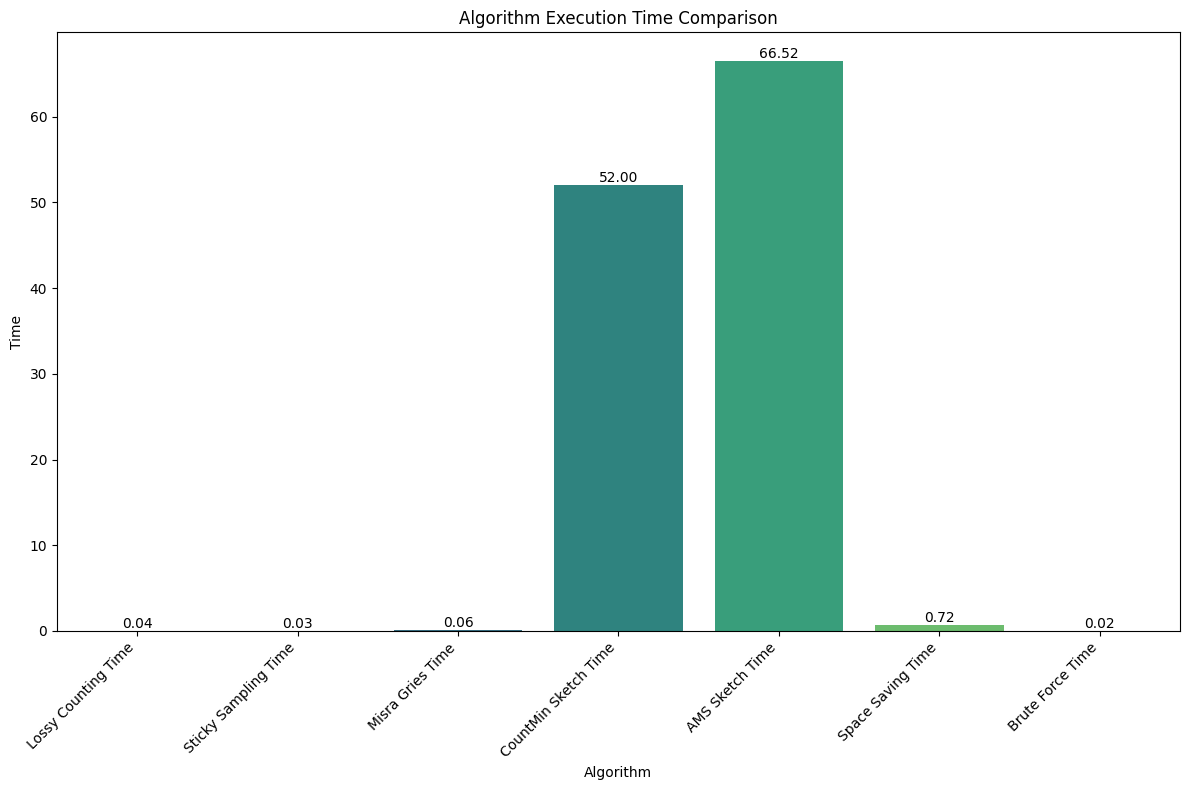

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


import pandas as pd

df = pd.DataFrame({
    'Algorithm': labels,
    'Time': times
})

# Create a bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='Algorithm', y='Time', palette='viridis')

# Adding data labels
for i in range(len(df)):
    plt.text(i, df['Time'][i], f"{df['Time'][i]:.2f}", ha='center', va='bottom')

# Formatting
plt.xticks(rotation=45, ha='right')
plt.title('Algorithm Execution Time Comparison')
plt.tight_layout()

# Show the plot
plt.show()


# Algorithm Execution Space Comparison

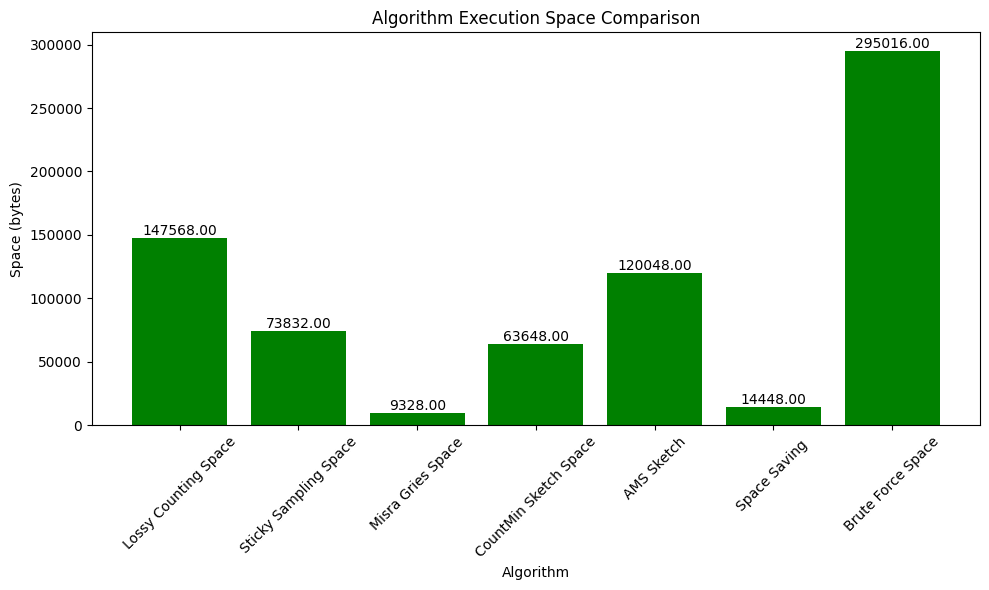

In [14]:
times = [lc_space, ss_space, mg_space, cm_space, ams_space, sss_space , bt_space]
labels = ['Lossy Counting Space', 'Sticky Sampling Space', 'Misra Gries Space', 'CountMin Sketch Space',"AMS Sketch" ,'Space Saving ', 'Brute Force Space']
plt.figure(figsize=(10, 6))
plt.bar(labels, times, color='green')
plt.title('Algorithm Execution Space Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Space (bytes)')
for i in range(len(times)):
    plt.text(i, times[i], f'{times[i]:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

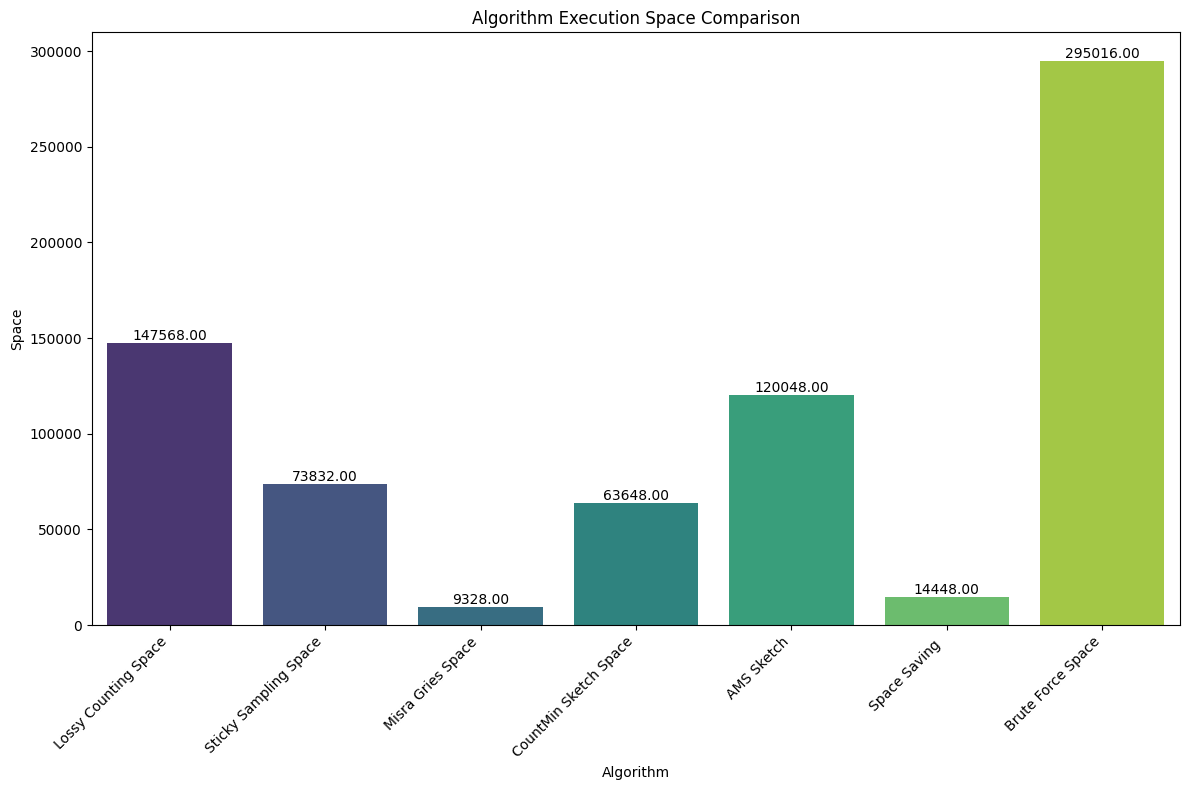

In [15]:
df = pd.DataFrame({
    'Algorithm': labels,
    'Space': times
})

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='Algorithm', y='Space', palette='viridis')

# Adding data labels
for i in range(len(df)):
    plt.text(i, df['Space'][i], f"{df['Space'][i]:.2f}", ha='center', va='bottom')

# Formatting
plt.xticks(rotation=45, ha='right')
plt.title('Algorithm Execution Space Comparison')
plt.tight_layout()

# Show the plot
plt.show()

# Algorithm Accuracy Comparison

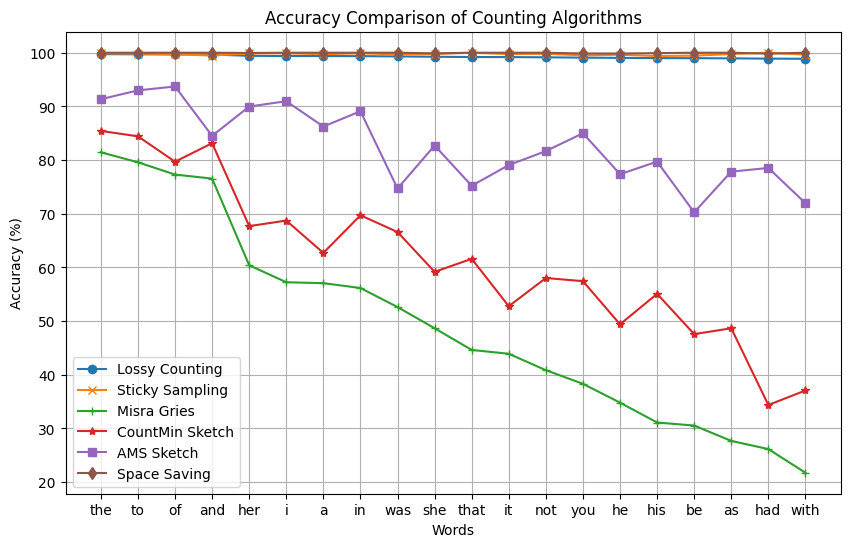

In [16]:

#words = ['the', 'to', 'of', 'and', 'her', 'i', 'a', 'in']
words = [i[0] for i in top_20_words]

bf_results = dict(bt_result.most_common(no_common))

def calculate_accuracy(algorithm_results):
    accuracies = []
    for word in words:
        bf_count = bf_results[word]
        algo_count = algorithm_results.get(word, 0)
        accuracy = (abs(algo_count - bf_count) / bf_count) * 100
        accuracies.append(100 - accuracy) 
    return accuracies


lc_accuracy = calculate_accuracy(lc_result)
ss_accuracy = calculate_accuracy(ss_result)
mg_accuracy = calculate_accuracy(dict(mg_result.most_common(no_common)))
cm_accuracy = calculate_accuracy(cm_result)
ams_accuracy = calculate_accuracy(ams_result)
sss_accuracy = calculate_accuracy(sss_compared)

plt.figure(figsize=(10, 6))
plt.plot(words, lc_accuracy, label='Lossy Counting', marker='o')
plt.plot(words, ss_accuracy, label='Sticky Sampling', marker='x')
plt.plot(words, mg_accuracy, label='Misra Gries', marker='+')
plt.plot(words, cm_accuracy, label='CountMin Sketch', marker='*')
plt.plot(words, ams_accuracy, label='AMS Sketch', marker='s')
plt.plot(words, sss_accuracy, label='Space Saving', marker='d')

plt.title('Accuracy Comparison of Counting Algorithms')
plt.xlabel('Words')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()


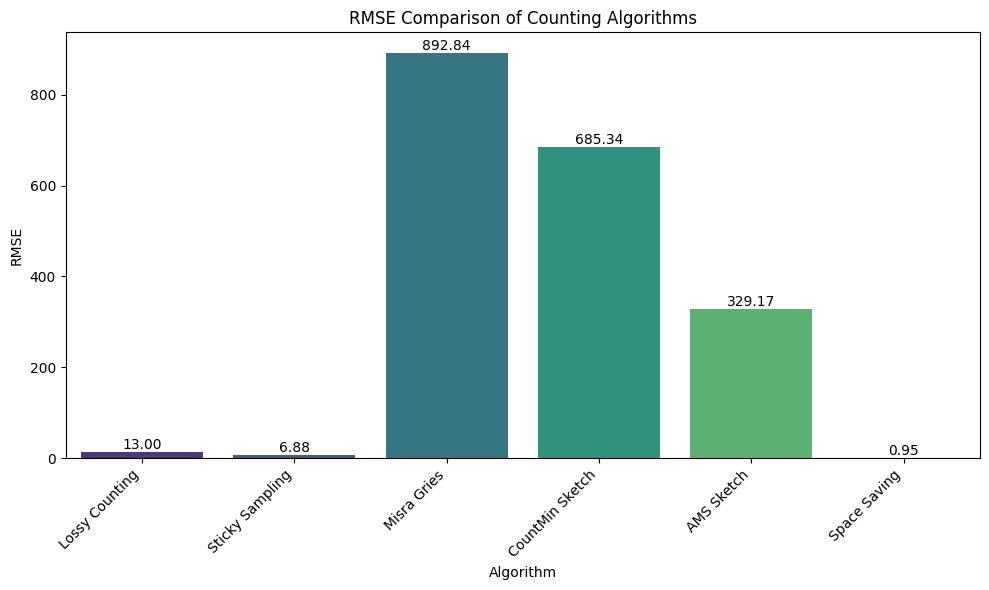

In [17]:
# import rmse
from sklearn.metrics import mean_squared_error
def calculate_rmse(algorithm_results):
    """
    Computes the RMSE between algorithm results and baseline results using sklearn's mean_squared_error.
    
    :param algorithm_results: Dictionary with word counts as key-value pairs.
    :return: RMSE value.
    """
    bf_counts = []
    algo_counts = []

    for word in words:
        bf_counts.append(bf_results.get(word, 0))
        algo_counts.append(algorithm_results.get(word, 0))

    # RMSE calculation using sklearn's mean_squared_error
    mse = mean_squared_error(bf_counts, algo_counts)
    return np.sqrt(mse)

# RMSE evaluations
lc_rmse = calculate_rmse(lc_result)
ss_rmse = calculate_rmse(ss_result)
mg_rmse = calculate_rmse(dict(mg_result.most_common(no_common)))
cm_rmse = calculate_rmse(cm_result)
ams_rmse = calculate_rmse(ams_result)
sss_rmse = calculate_rmse(sss_compared)




# Data preparation for plotting
rmse_values = [lc_rmse, ss_rmse, mg_rmse, cm_rmse, ams_rmse, sss_rmse]
labels = ['Lossy Counting', 'Sticky Sampling', 'Misra Gries', 'CountMin Sketch', 'AMS Sketch', 'Space Saving']

df = pd.DataFrame({
    'Algorithm': labels,
    'RMSE': rmse_values
})

# Seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Algorithm', y='RMSE', palette='viridis')

# Add labels directly onto the bars
for i in range(len(df)):
    plt.text(i, df['RMSE'][i], f"{df['RMSE'][i]:.2f}", ha='center', va='bottom')

# Formatting
plt.xticks(rotation=45, ha='right')
plt.title('RMSE Comparison of Counting Algorithms')
plt.tight_layout()

# Display the plot
plt.show()
